# Climate scenario data

In this notebook we will...
1. ... aggregate and download climate scenario data from the Coupled Model Intercomparison Project Phase 6 ([CMIP6](https://wcrp-cmip.org/cmip-phase-6-cmip6/)) for our catchment,
2. ... preprocess the data,
3. ... compare the CMIP6 models with our reanalysis data and adjust them for biases,
4. ... and visualize the data before and after bias adjustment.

The [NEX-GDDP-CMIP6 dataset](https://www.nature.com/articles/s41597-022-01393-4) we are going to use has been downscaled to 27830 m resolution by the [NASA Climate Analytics Group](https://www.nature.com/articles/s41597-022-01393-4) and is available in two [Shared Socio-Economic Pathways](https://unfccc.int/sites/default/files/part1_iiasa_rogelj_ssp_poster.pdf) (SSP2 and SSP5). It is available via [Google Earth Engine](https://developers.google.com/earth-engine/datasets/catalog/NASA_GDDP-CMIP6#bands) which makes it subsettable on the server side and the download files relatively lightweight.

We start by reading the config and initializing the Google Earth Engine access again.

In [68]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)     # Suppress Deprecation Warnings
import configparser
import ast
import geopandas as gpd
import ee
import geemap
import numpy as np


# read local config.ini file
config = configparser.ConfigParser()
config.read('config.ini')

# get paths from config.ini
dir_output = config['FILE_SETTINGS']['DIR_OUTPUT']
dir_figures = config['FILE_SETTINGS']['DIR_FIGURES']
output_gpkg = dir_output + config['FILE_SETTINGS']['GPKG_NAME']
zip_output = config['CONFIG']['ZIP_OUTPUT']

# get style for matplotlib plots
# plt_style = ast.literal_eval(config['CONFIG']['PLOT_STYLE'])

# set the file format for storage
compact_files = config.getboolean('CONFIG','COMPACT_FILES')

# read cloud-project
cloud_project = config['CONFIG']['CLOUD_PROJECT']

# initialize GEE
try:
    ee.Initialize(project=cloud_project)
except Exception as e:
    ee.Authenticate()
    ee.Initialize(project=cloud_project)

Now we can send the catchment outline to GEE to use it as target polygon for aggregation.

In [69]:
# load catchment outline as target polygon
catchment_new = gpd.read_file(output_gpkg, layer='catchment_new')
catchment = geemap.geopandas_to_ee(catchment_new)
print("Catchment outline converted to GEE polygon.")

# name target subdirectory to be created
cmip_dir = dir_output + 'cmip6/'

Catchment outline converted to GEE polygon.


## Select, aggregate, and download downscaled CMIP6 data

We have designed a class called `CMIPDownloader` that does everything promised in the heading in one go. The `buildFeature()` function requests daily catchment wide averages of all available CMIP6 models for individual years. All requested years are stored in an `ee.ImageCollection` by the`getResult()` function. To provide the best basis for bias adjustment, a large overlap of reanalysis and scenario data is recommended. By default, the `CMIPDownloader` class requests everything between the earliest available date from ERA5 (1979) and the latest available date from CMIP6 (2100). The `download()` function then starts a given number of parallel requests, each downloading a single year and saving it as a CSV file.

We can simply specify a target location and start the download for both variables individually. If you are in a binder or only have few CPUs available, choose a moderate number of requests to avoid "hickups". The download time depends on the number of parallel processes, the traffic on the GEE servers and other mysterious factors. If you run this notebook in a binder, it usually doesn't take more than 5 minutes for both downloads to finish.

In [3]:
from tools.geetools import CMIPDownloader

downloader_t = CMIPDownloader(var='tas', starty=1979, endy=2100, shape=catchment, processes=30, dir=cmip_dir)
downloader_t.download()
downloader_p = CMIPDownloader(var='pr', starty=1979, endy=2100, shape=catchment, processes=30, dir=cmip_dir)
downloader_p.download()

Initiating download request for NEX-GDDP-CMIP6 data from 1979 to 2100.


All downloads complete.
Initiating download request for NEX-GDDP-CMIP6 data from 1979 to 2100.


All downloads complete.


We have now downloaded individual files for each year and variable and stored them in `output/cmip_dir`. To use them as model forcing data, they need to be processed.

## Processing CMIP6 data

The corresponding `CMIPProcessor` class will read all downloaded CSV files and concatenate them into a single file per scenario. It also checks for consistency and drops models that are not available for individual years or scenarios. It processes variables individually and returns a single dataframe for each of the two scenarios from 1979 to 2100.

In [70]:
from tools.geetools import CMIPProcessor

cmip_dir = dir_output + 'cmip6/'

processor_t = CMIPProcessor(file_dir=cmip_dir, var='tas')
ssp2_tas_raw, ssp5_tas_raw = processor_t.get_results()

processor_p = CMIPProcessor(file_dir=cmip_dir, var='pr')
ssp2_pr_raw, ssp5_pr_raw = processor_p.get_results()

Let's have a look. We can see that our scenario dataset now contains a fairly large number of CMIP6 models in alphabetical order.

In [71]:
print(ssp2_tas_raw.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 44560 entries, 1979-01-01 to 2100-12-31
Data columns (total 32 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ACCESS-CM2        44560 non-null  float64
 1   ACCESS-ESM1-5     44560 non-null  float64
 2   BCC-CSM2-MR       44560 non-null  float64
 3   CESM2             44560 non-null  float64
 4   CESM2-WACCM       44560 non-null  float64
 5   CMCC-CM2-SR5      44560 non-null  float64
 6   CMCC-ESM2         44560 non-null  float64
 7   CNRM-CM6-1        44560 non-null  float64
 8   CNRM-ESM2-1       44560 non-null  float64
 9   CanESM5           44560 non-null  float64
 10  EC-Earth3         44560 non-null  float64
 11  EC-Earth3-Veg-LR  44560 non-null  float64
 12  FGOALS-g3         44560 non-null  float64
 13  GFDL-CM4_gr1      44560 non-null  float64
 14  GFDL-CM4_gr2      44560 non-null  float64
 15  GFDL-ESM4         44560 non-null  float64
 16  GISS-E2-1-G       44560

If we want to check which models failed the consistency check of the `CMIPProcessor` we can use its `dropped_models` attribute.

In [72]:
print('Models that failed the consistency checks:\n')
print(processor_t.dropped_models)

Models that failed the consistency checks:

['HadGEM3-GC31-MM', 'IITM-ESM']


## Bias adjustment using reananlysis data

Due to the coarse resolution of global climate models (GCMs) and the extensive correction of reanalysis data there is substantial bias between the two datasets. To force a glacio-hydrological model calibrated on reanalysis data with climate scenarios this bias needs to be adressed. We will use a method developed by [Switanek et.al. (2017)](https://doi.org/10.5194/hess-21-2649-2017) called **Scaled Distribution Mapping (SDM)** to correct for bias while preserving trends and the likelihood of meteorological events in the raw GCM data. The method has been implemented in the [`bias_correction`](https://github.com/pankajkarman/bias_correction) Python library by [Pankaj Kumar](https://pankajkarman.github.io/). As suggested by the authors we will apply the bias adjustment to discrete blocks of data individually. The `adjust_bias()` function loops over all models and adjusts them to the reanalysis data in the overlap period (1979 to 2024).
The function is applied separately to each variable and scenario. The `bias_adjustment` library provides a normal and a gamma distribution as a basis for the SDM. As the distribution of the ERA5 Land precipitation data is actually closer to a normal distribution with a cut-off of 0 mm, we use the `normal_mapping` method for both variables.

The function is applied separately to each variable and scenario. The `bias_adjustment` library provides a normal and a gamma distribution as a basis for the SDM. As the distribution of the ERA5 Land precipitation data is actually closer to a normal distribution with a cut-off of 0 mm, we use the `normal_mapping` method for both variables.

In [73]:
from tools.helpers import adjust_bias

era5_file = dir_output + 'ERA5L.csv'

print("SSP2 Temperature:")
ssp2_tas = adjust_bias(predictand=ssp2_tas_raw, predictor=era5_file)
print("SSP5 Temperature:")
ssp5_tas = adjust_bias(predictand=ssp5_tas_raw, predictor=era5_file)
print("SSP2 Precipitation:")
ssp2_pr = adjust_bias(predictand=ssp2_pr_raw, predictor=era5_file)
print("SSP5 Precipitation:")
ssp5_pr = adjust_bias(predictand=ssp5_pr_raw, predictor=era5_file)

SSP2 Temperature:


Bias Correction: 100%|███████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.25it/s]


SSP5 Temperature:


Bias Correction: 100%|███████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.15it/s]


SSP2 Precipitation:


Bias Correction: 100%|███████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.21it/s]


SSP5 Precipitation:


Bias Correction: 100%|███████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.21it/s]


The result is a comprehensive dataset of several models over 122 years in two versions (pre- and post-adjustment) for every variable. To see what's in the data and what happened during bias adjustment we need an overview.

## 	Visualization

The first plot will contain simple timeseries. The first function `cmip_plot()` resamples the data so a given frequency and creates a single plot. `cmip_plot_combined()` arranges multiple plots for both scenarios before and after bias adjustment.

### Time series

First, we store our raw and adjusted data in dictionaries. By default, the data is smoothed with a 10-year moving average (`smooting_window=10`). Precipitation data is aggregated to annual totals (`agg_level='annual'`). You can customise this by specifying the appropriate arguments.

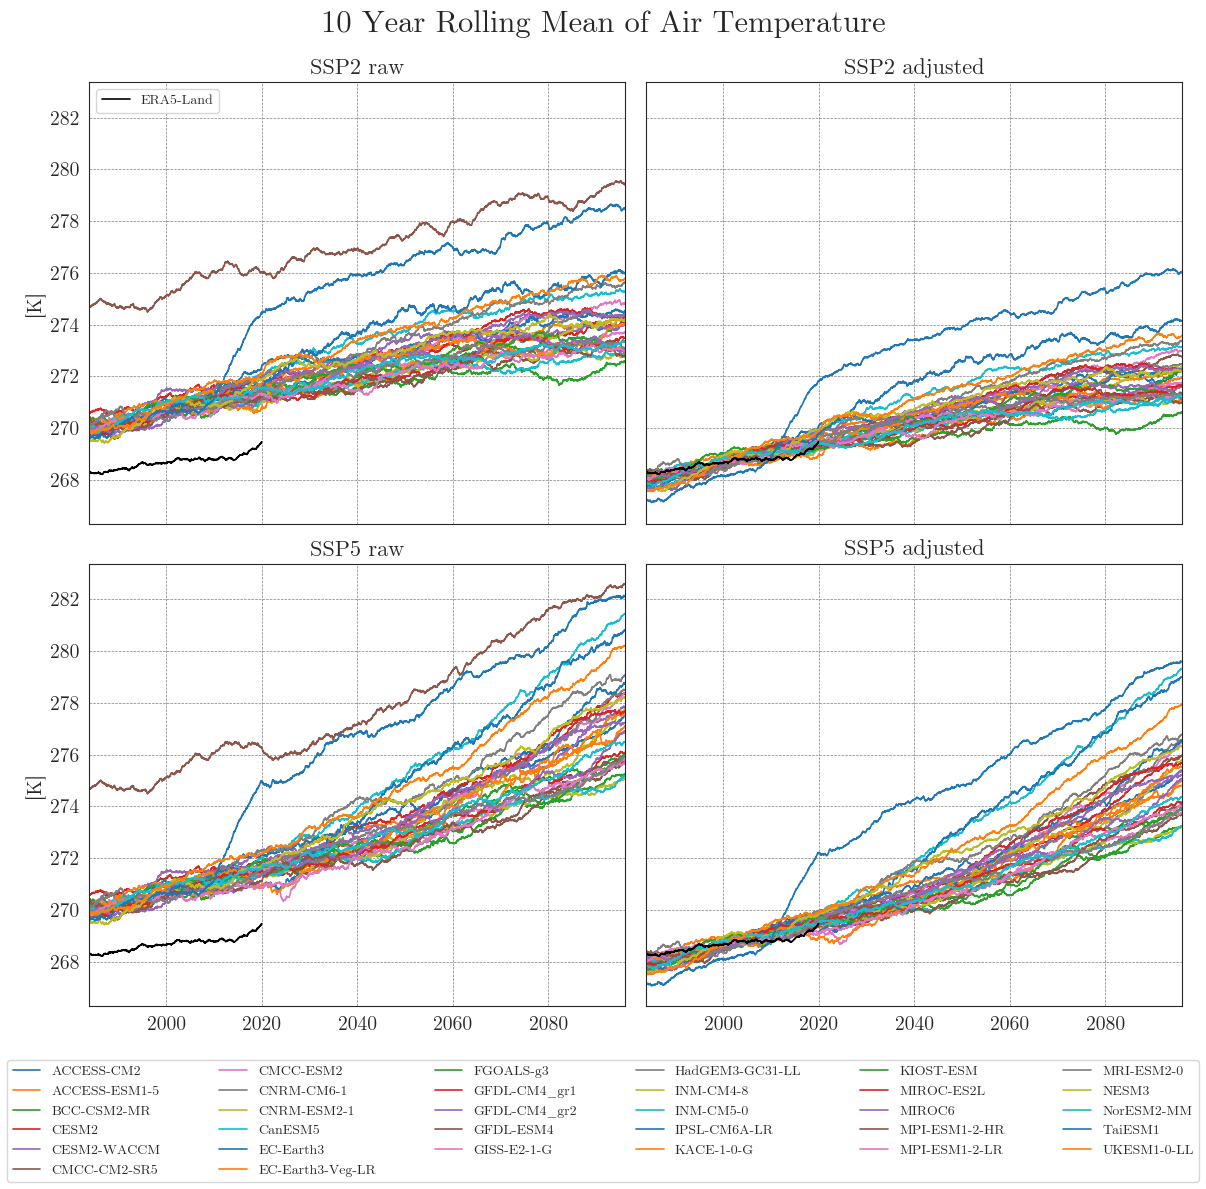

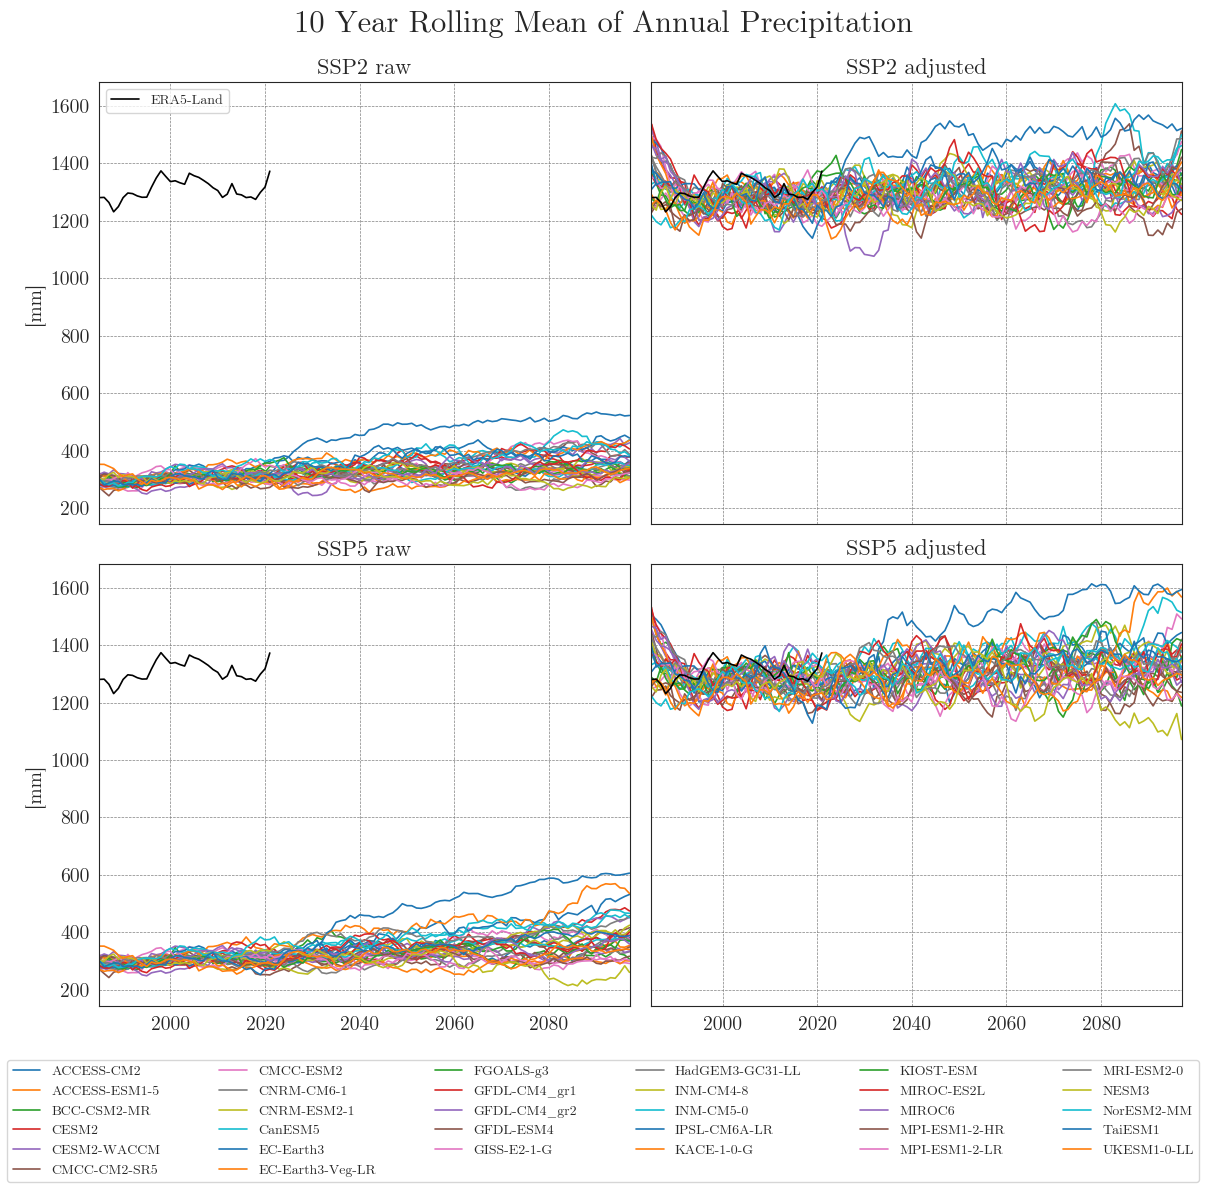

In [74]:
from tools.helpers import read_era5l
from tools.plots import cmip_plot_combined

# store CMIP6 data in dictionaries
ssp_tas_dict = {'SSP2_raw': ssp2_tas_raw, 'SSP2_adjusted': ssp2_tas, 'SSP5_raw': ssp5_tas_raw, 'SSP5_adjusted': ssp5_tas}
ssp_pr_dict = {'SSP2_raw': ssp2_pr_raw, 'SSP2_adjusted': ssp2_pr, 'SSP5_raw': ssp5_pr_raw, 'SSP5_adjusted': ssp5_pr}

era5 = read_era5l(era5_file)

cmip_plot_combined(data=ssp_tas_dict, target=era5, target_label='ERA5-Land', smooth_window=10, show=True, fig_path=f"{dir_figures}NB3_CMIP6_Temp.png")
cmip_plot_combined(data=ssp_pr_dict, target=era5, precip=True, target_label='ERA5-Land', agg_level='annual', smooth_window=10, show=True, fig_path=f"{dir_figures}NB3_CMIP6_Prec.png")

Apparently, some models have striking curves indicating unrealistic outliers or sudden jumps in the data. To clearly identify faulty time series, one option is to choose a qualitative approach by identifying the models using an interactive `plotly` plot. Here we can zoom and select/deselect curves as we like, to identify model names.

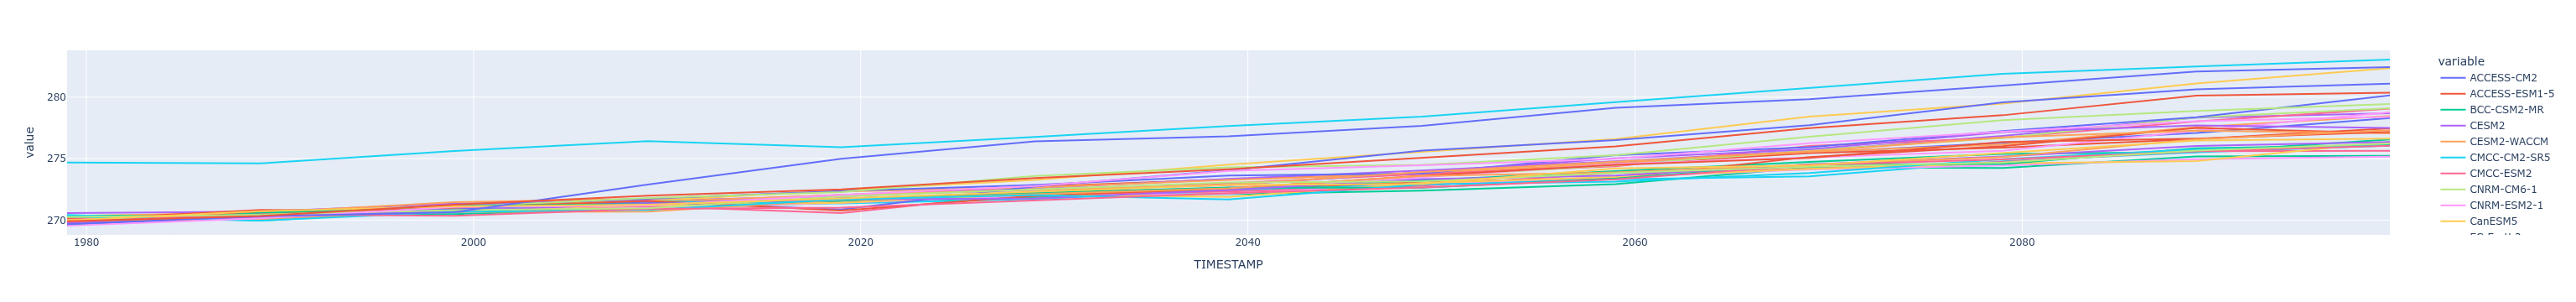

In [75]:
import plotly.express as px

fig = px.line(ssp5_tas_raw.resample('10YE', closed='left', label='left').mean())
fig.show()

### Violin plots

To look at it from a different perpective we can also have a look at the individual distributions of all models. A nice way to cover several aspects at once is to use `seaborne` [violinplots](https://seaborn.pydata.org/generated/seaborn.violinplot.html).

First we have to rearrange our input dictionaries a little bit. For comparison the `vplots()` function will arrange the plots in a similar grid as in the figures above.

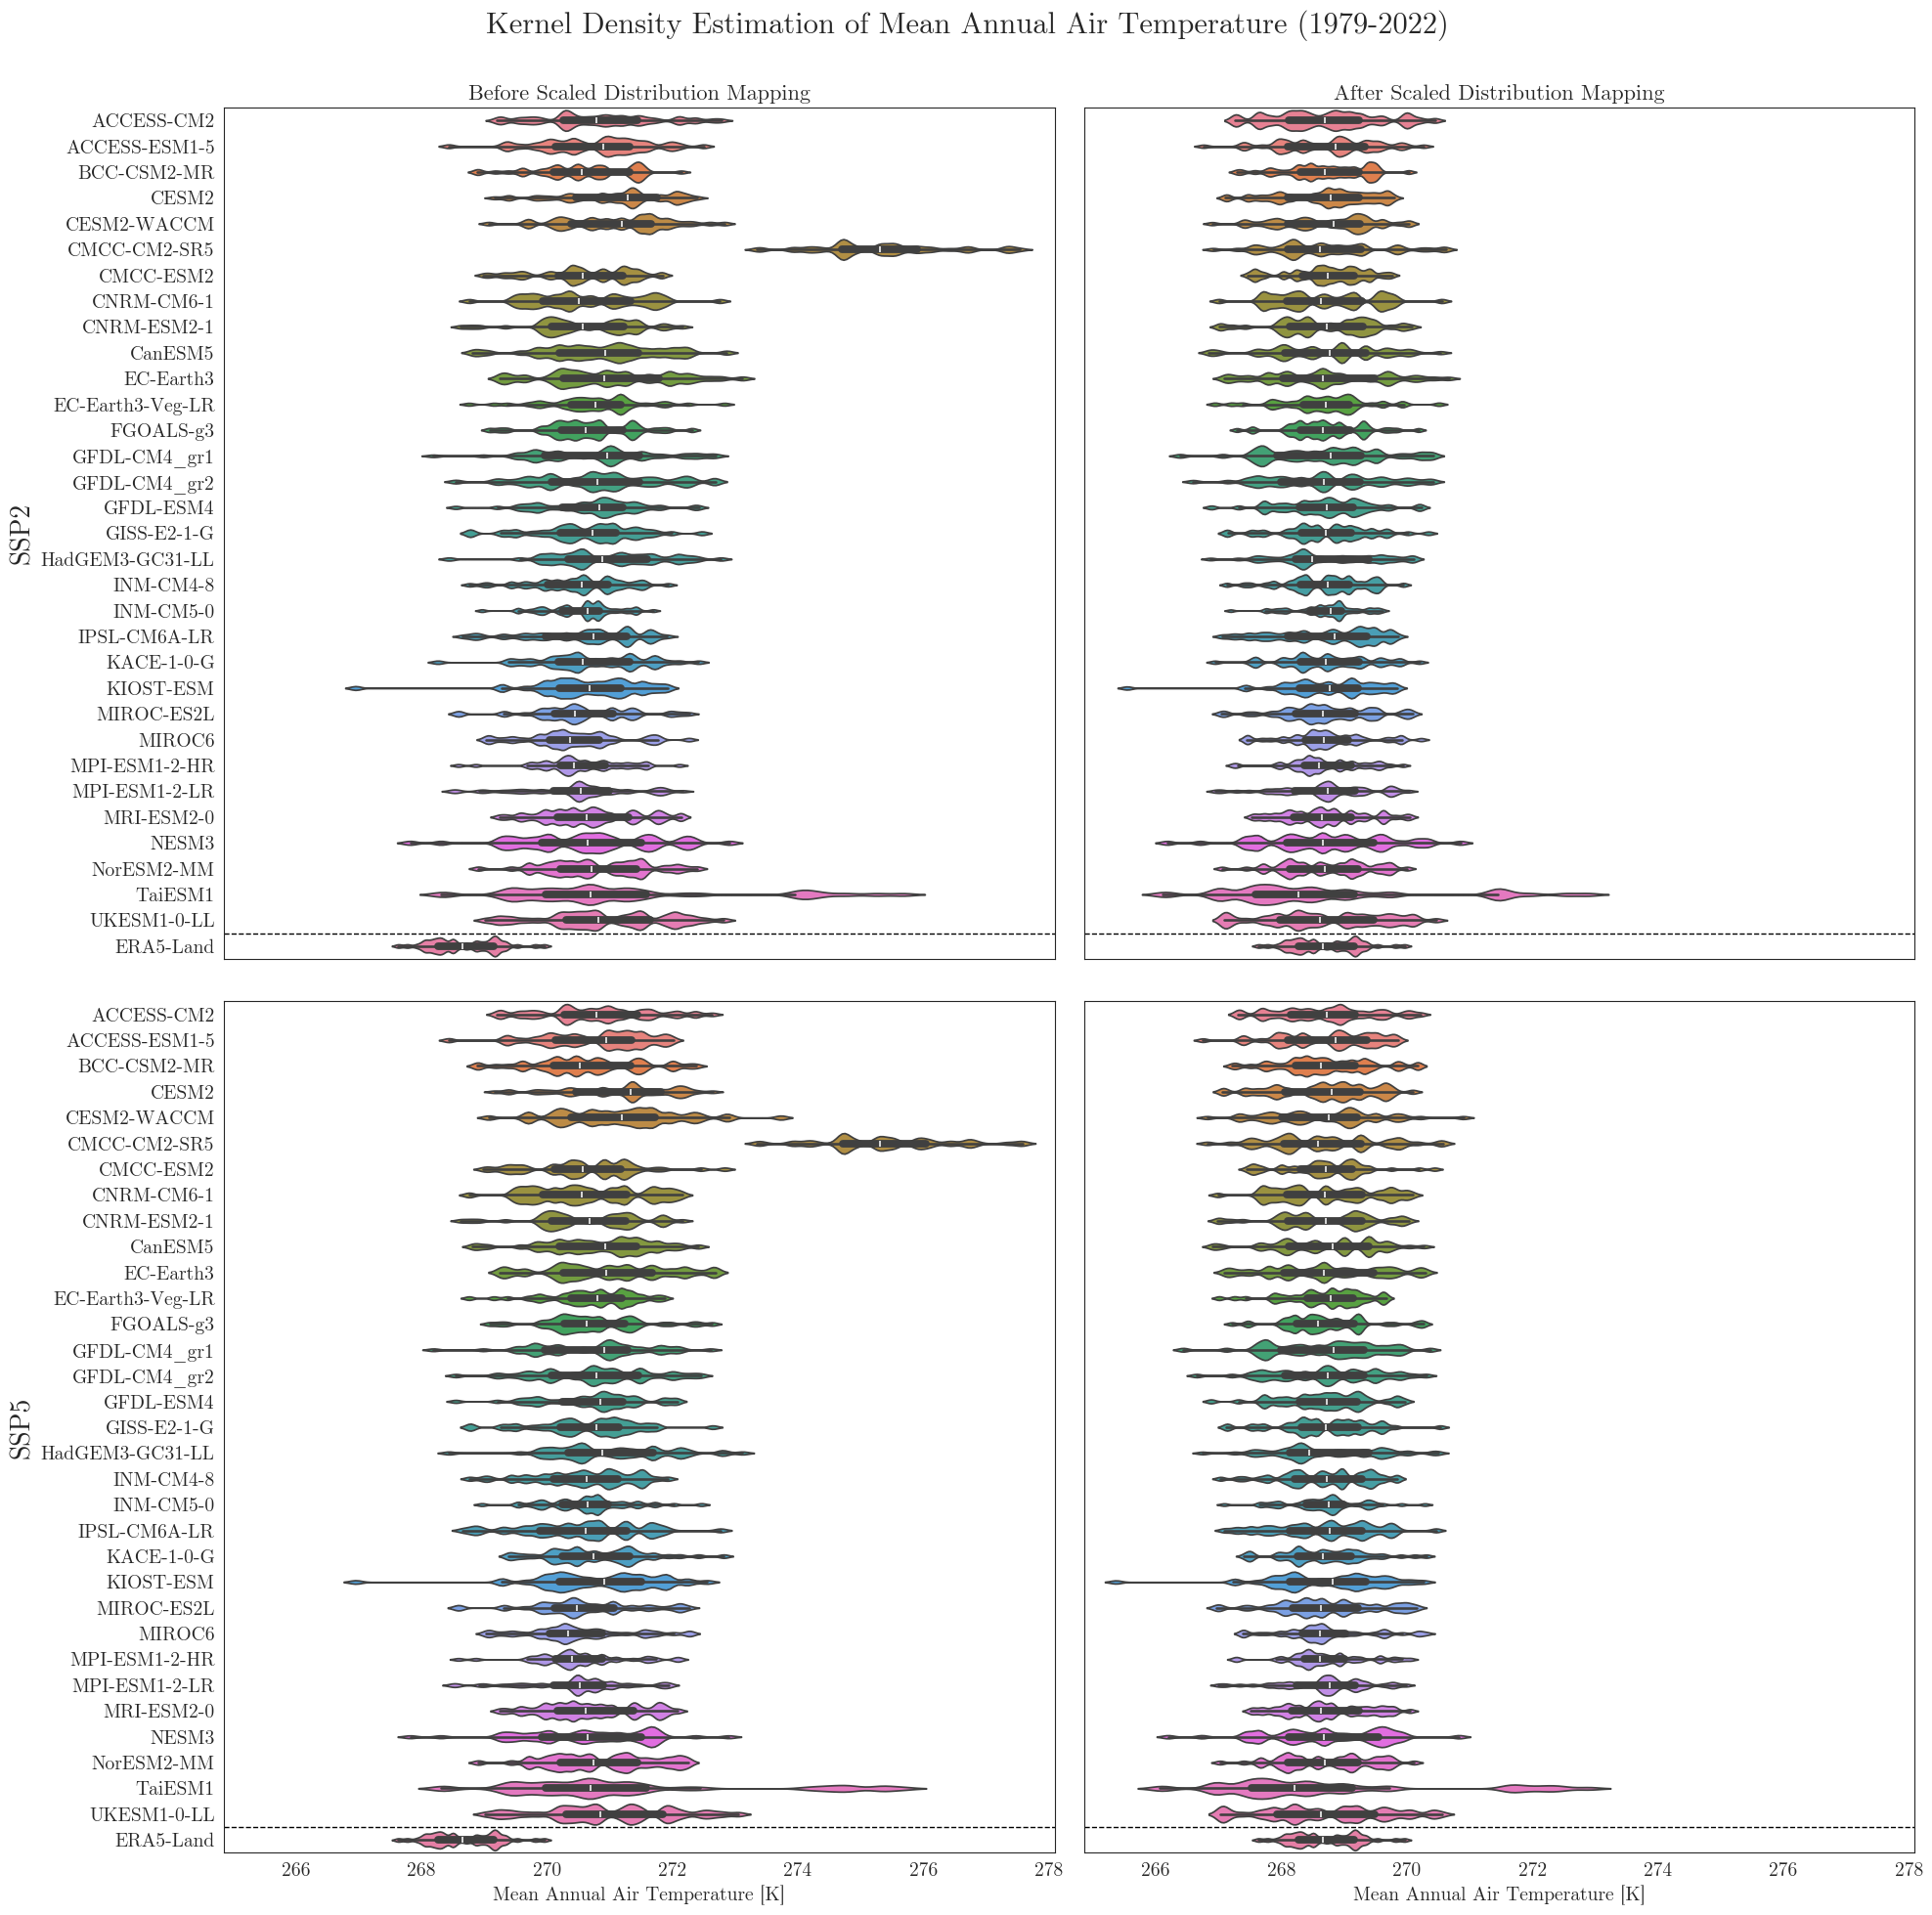

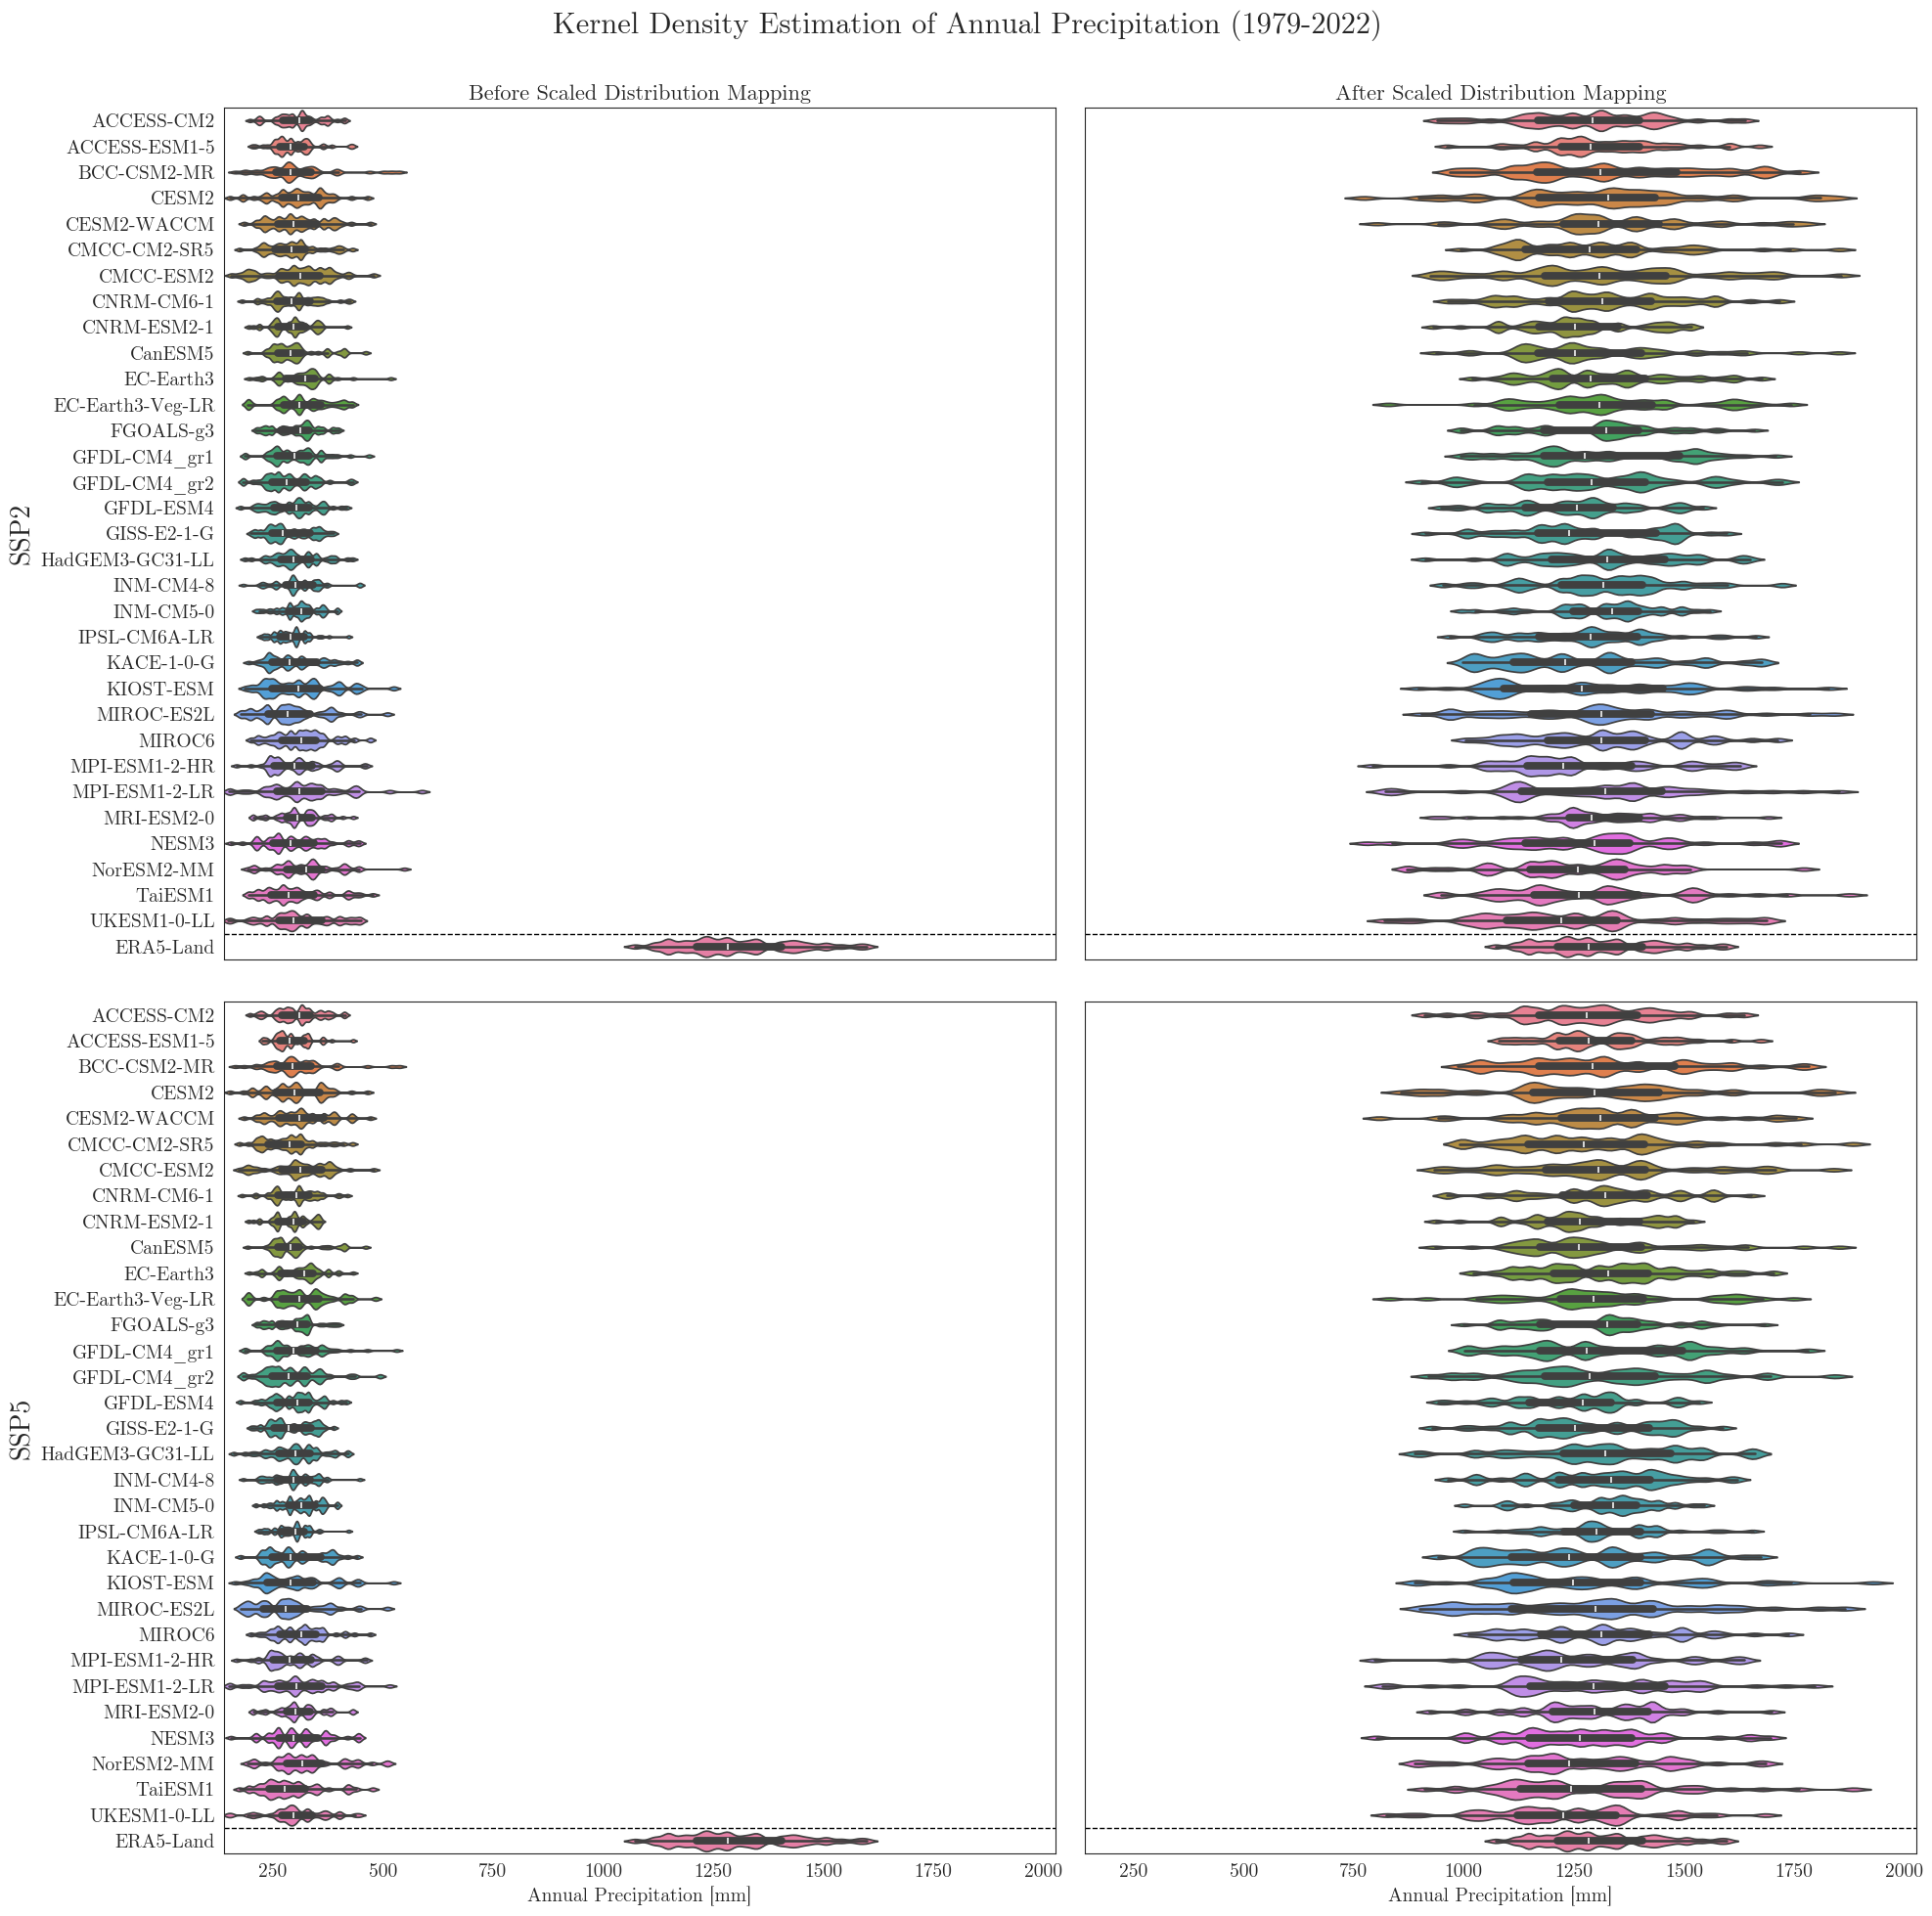

In [76]:
from tools.helpers import dict_filter
from tools.plots import vplots

tas_raw = dict_filter(ssp_tas_dict, 'raw')
tas_adjusted = dict_filter(ssp_tas_dict, 'adjusted')
pr_raw = dict_filter(ssp_pr_dict, 'raw')
pr_adjusted = dict_filter(ssp_pr_dict, 'adjusted')

vplots(tas_raw, tas_adjusted, era5, target_label='ERA5-Land', show=True, fig_path=f"{dir_figures}NB3_vplot_Temp.png")
vplots(pr_raw, pr_adjusted, era5, target_label='ERA5-Land', precip=True, show=True, fig_path=f"{dir_figures}NB3_vplot_Prec.png")

### Data filters

Since we have a large number of models and some problems may be difficult to identify in a plot, we can use some standard filters combined in the `DataFilter` class. By default it filters models that contain ...

  ... outliers deviating more than 3 standard deviations from the mean (`zscore_threshold`) and/or ...

  ... increases/decreases of more than 5 units in a single timestep (`jump_threshold`).

The functions can be applied separately (`check_outliers` or `check_jumps`) or together (`filter_all`). All three return a `list` of model names.

Here, we also use the `resampling_rate` argument to resample the data to annual means (`'YE'`) before running the checks.

<div class="alert alert-block alert-info">
    <b>Note:</b> While extreme temperature outliers are easy to identify, precipitation data is more variable between models and requires careful evaluation. In this example, we remove only models failing the temperature checks from the ensemble. Adjust the filters to your needs and use them for precipitation if you know what your are doing. 
</div>

In [77]:
from tools.helpers import DataFilter

filter = DataFilter(ssp2_tas_raw, zscore_threshold=3, jump_threshold=5, resampling_rate='YE')

print('Models with temperature outliers: ' + str(filter.outliers))
print('Models with temperature jumps: ' + str(filter.jumps))
print('Models with either one or both: ' + str(filter.filtered_models))

Models with temperature outliers: ['KIOST-ESM']
Models with temperature jumps: []
Models with either one or both: ['KIOST-ESM']


The identified columns can then be removed from the CMIP6 ensemble dataset using another helper function. We run the `drop_model()` function on the dictionaries of all variables and run `cmip_plot_combined()` again to check the result.

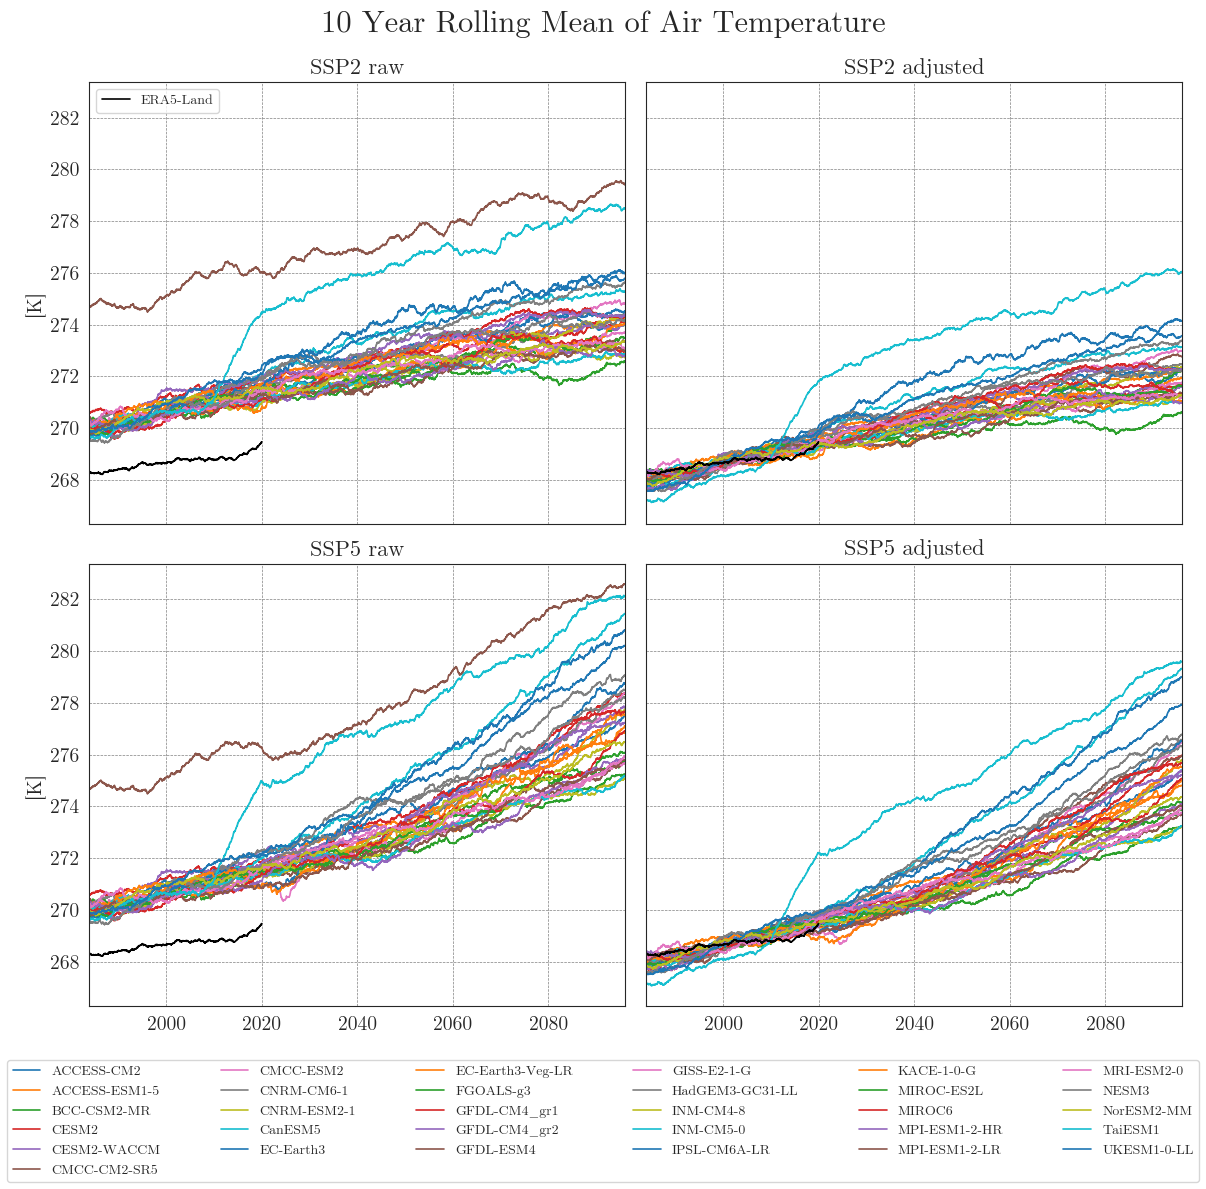

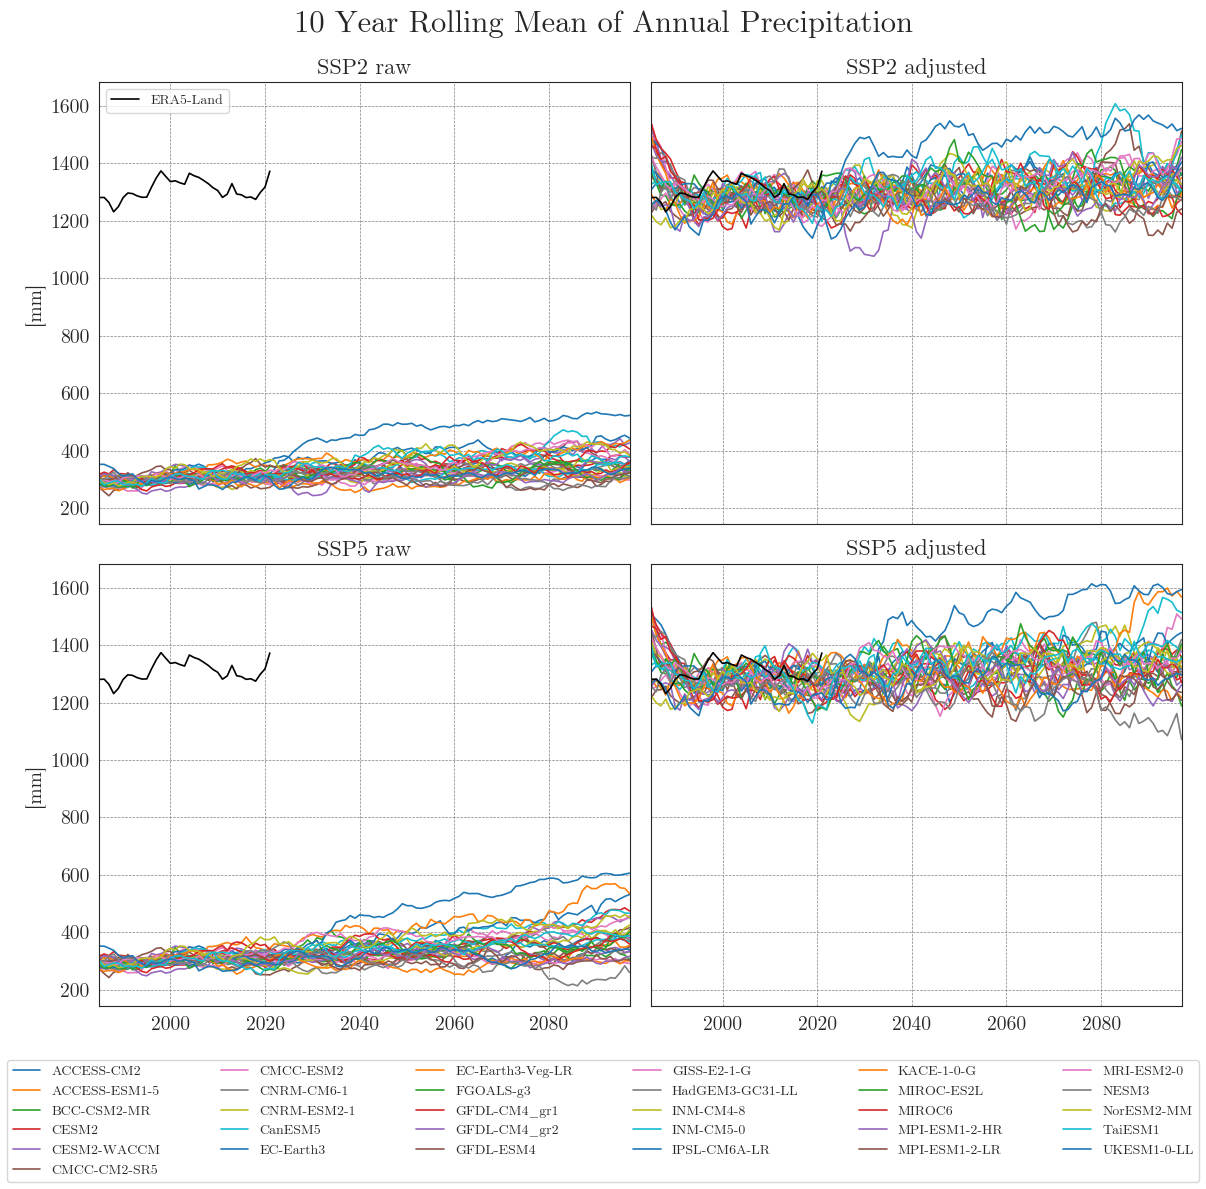

In [78]:
from tools.helpers import drop_model

ssp_tas_dict = drop_model(filter.filtered_models, ssp_tas_dict)
ssp_pr_dict = drop_model(filter.filtered_models, ssp_pr_dict)


cmip_plot_combined(data=ssp_tas_dict, target=era5, target_label='ERA5-Land', show=True, fig_path=f"{dir_figures}NB3_CMIP6_Temp_filtered.png")
cmip_plot_combined(data=ssp_pr_dict, target=era5, precip=True, target_label='ERA5-Land', show=True, agg_level='annual', smooth_window=10, fig_path=f"{dir_figures}NB3_CMIP6_Prec_filtered.png")

### Ensemble mean plots

Now that we no longer need to focus on individual models, we can reduce the number of lines by plotting only the ensemble means with a 90% confidence interval. With fewer lines in the plot, we can also reduce the resampling frequency and display the annual means.

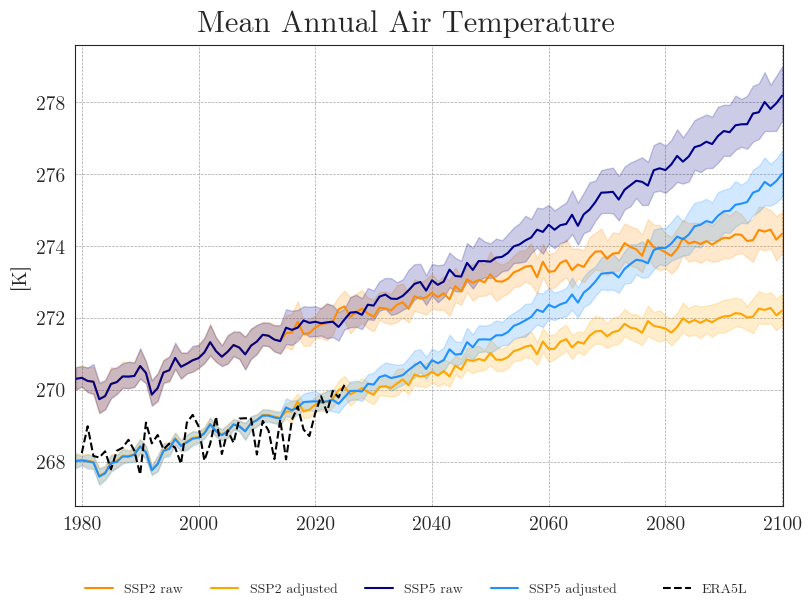

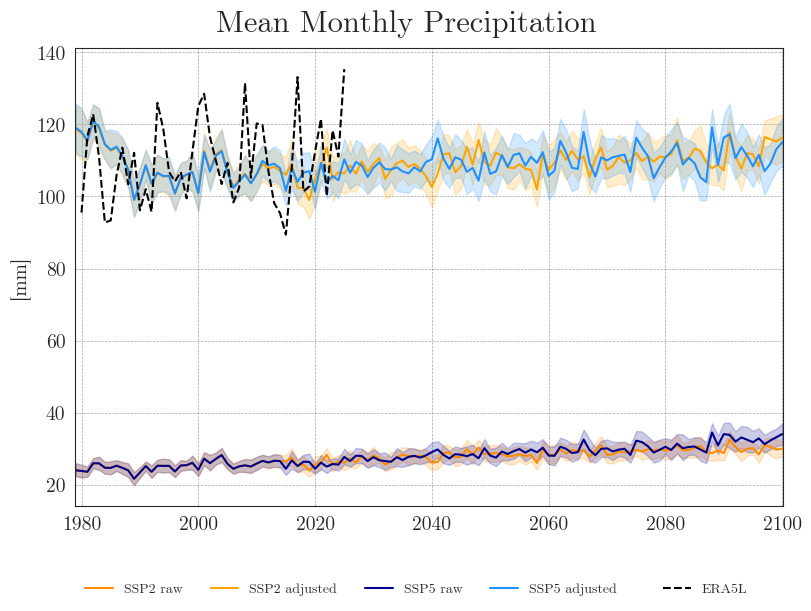

In [79]:
from tools.plots import cmip_plot_ensemble

cmip_plot_ensemble(ssp_tas_dict, era5['temp'], intv_mean='YE', fig_path=f'{dir_figures}NB3_CMIP6_Ensemble_Temp.png')
cmip_plot_ensemble(ssp_pr_dict, era5['prec'], precip=True, intv_sum='ME', intv_mean='YE', fig_path=f'{dir_figures}NB3_CMIP6_Ensemble_Prec.png')

We can see that the SDM adjusts the range and mean of the target data while preserving the distribution and trend of the original data. However, the inter-model variance is slightly reduced for temperature and notably increased for precipitation.

Last but not least, we will have a closer look at the performance of the bias adjustment. To do that, we will create probability plots for all models comparing original, target, and adjusted data with each other and a standard normal distribution. The `prob_plot` function creates such a plot for an individual model and scenario. The `pp_matrix` function loops the `prob_plot` function over all models in a `DataFrame` and arranges them in a matrix.

First we'll have a look at the temperature.

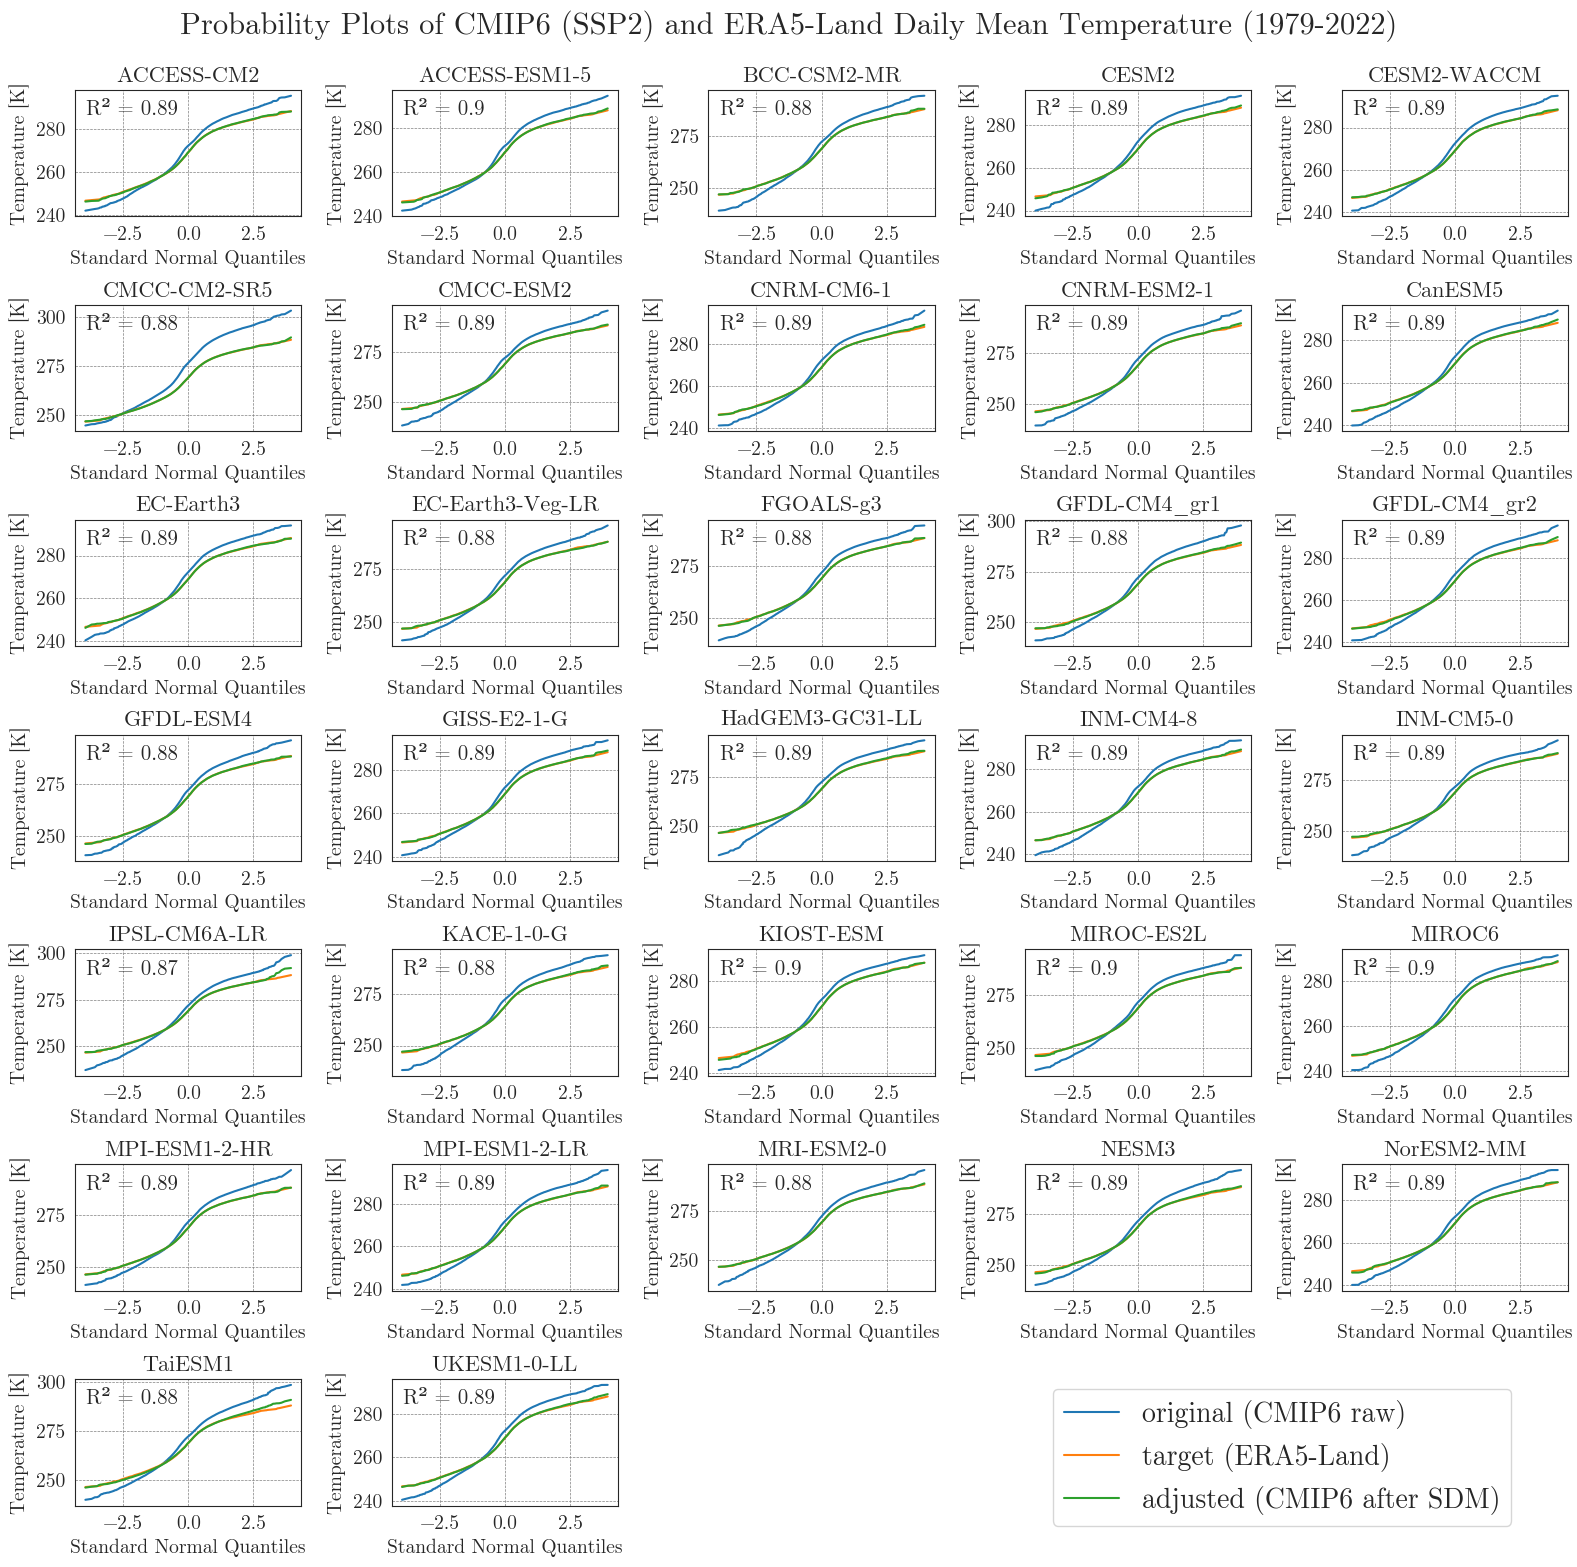

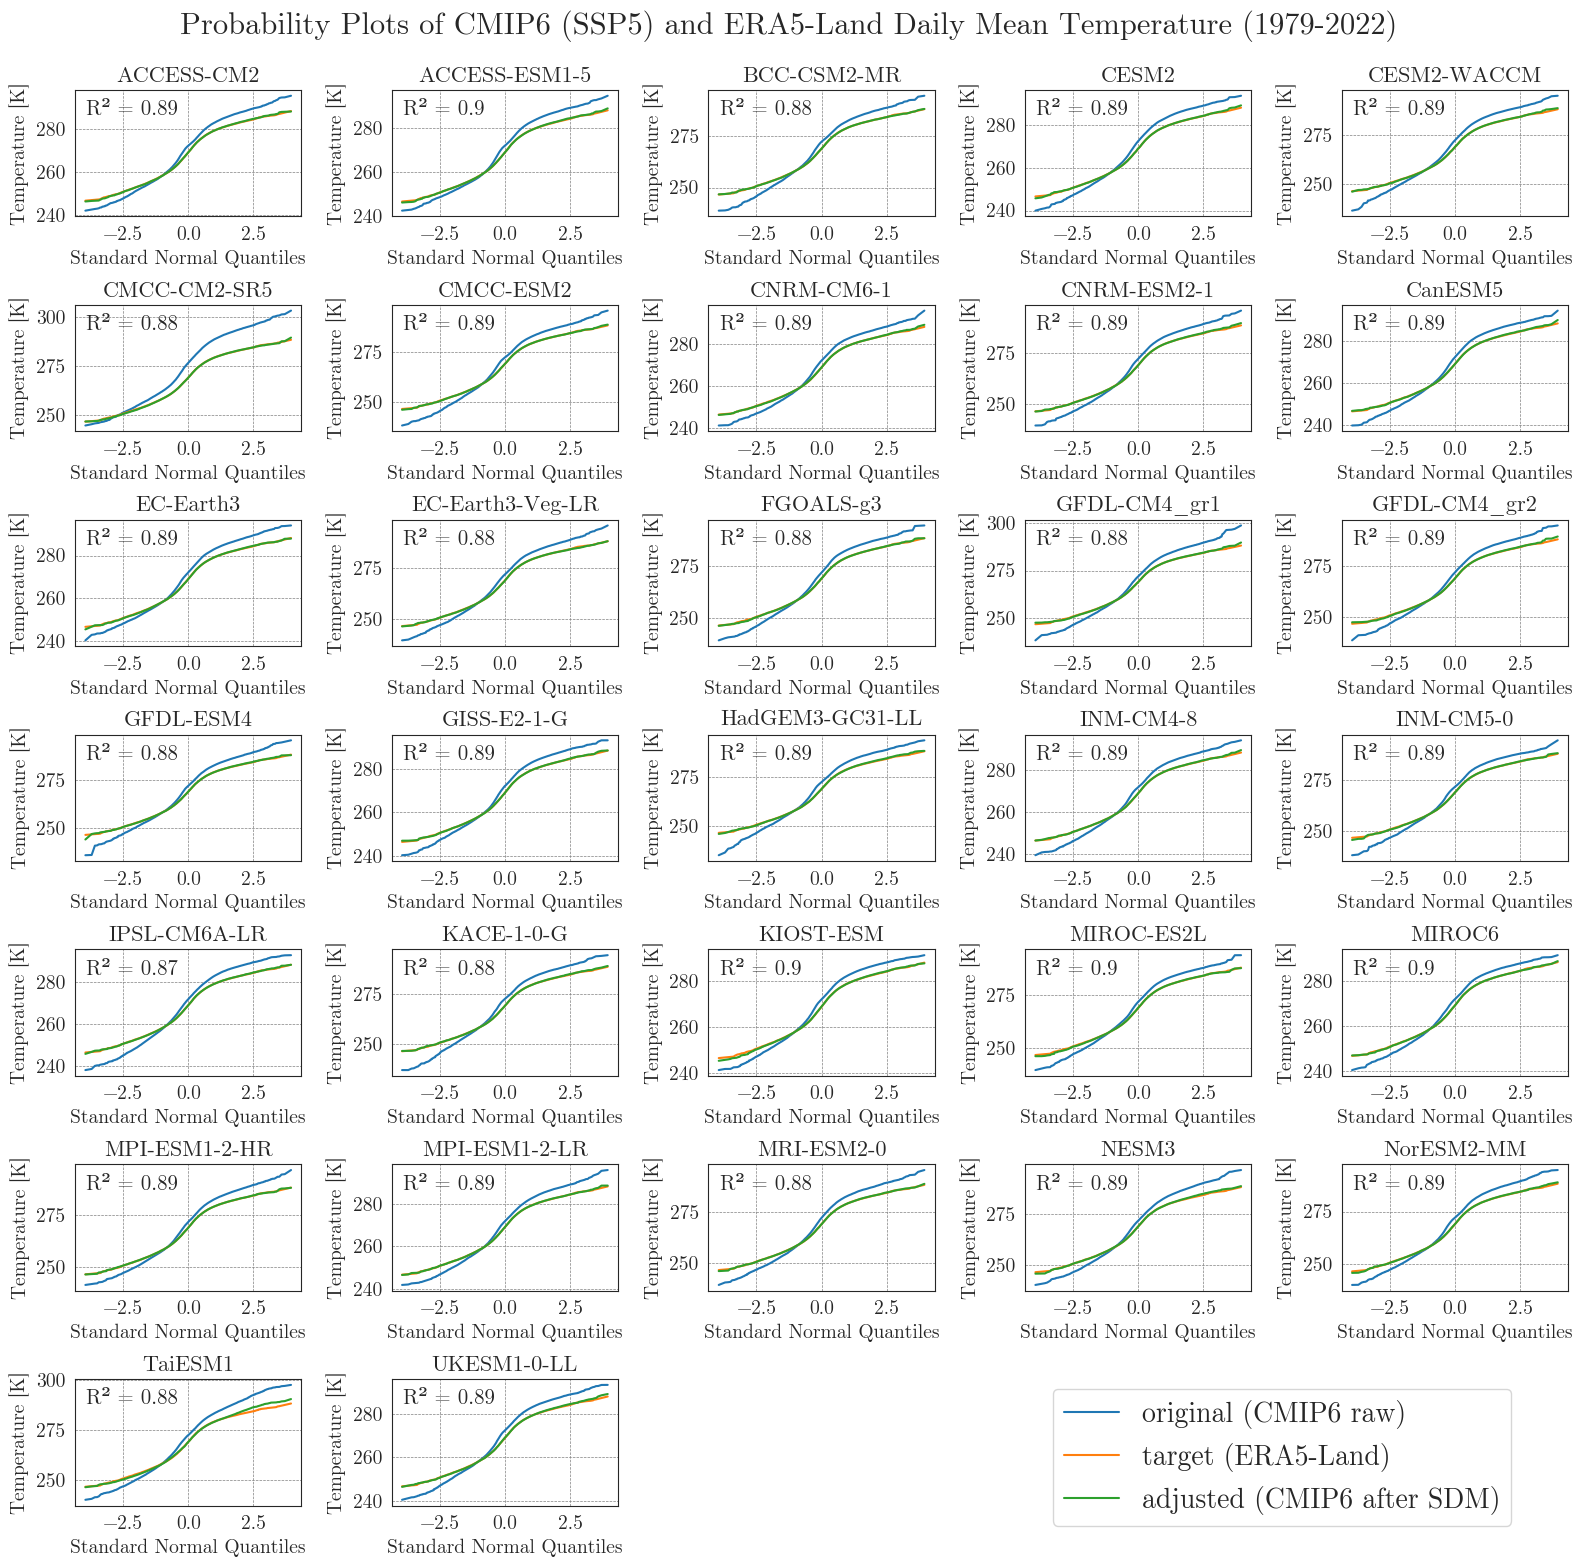

In [80]:
from tools.plots import pp_matrix

pp_matrix(ssp2_tas_raw, era5['temp'], ssp2_tas, scenario='SSP2', show=True, fig_path=f'{dir_figures}NB3_CMIP6_SSP2_probability_Temp.png')
pp_matrix(ssp5_tas_raw, era5['temp'], ssp5_tas, scenario='SSP5', show=True, fig_path=f'{dir_figures}NB3_CMIP6_SSP5_probability_Temp.png')

We can see that the SDM worked very well for the temperature data, with high agreement between the target and adjusted data.

Now, let's examine the probability curves for precipitation. Since the precipitation data is bounded at 0 mm and most days have small values greater than 0 mm, we resample the data as monthly sums to get an idea of the overall performance.

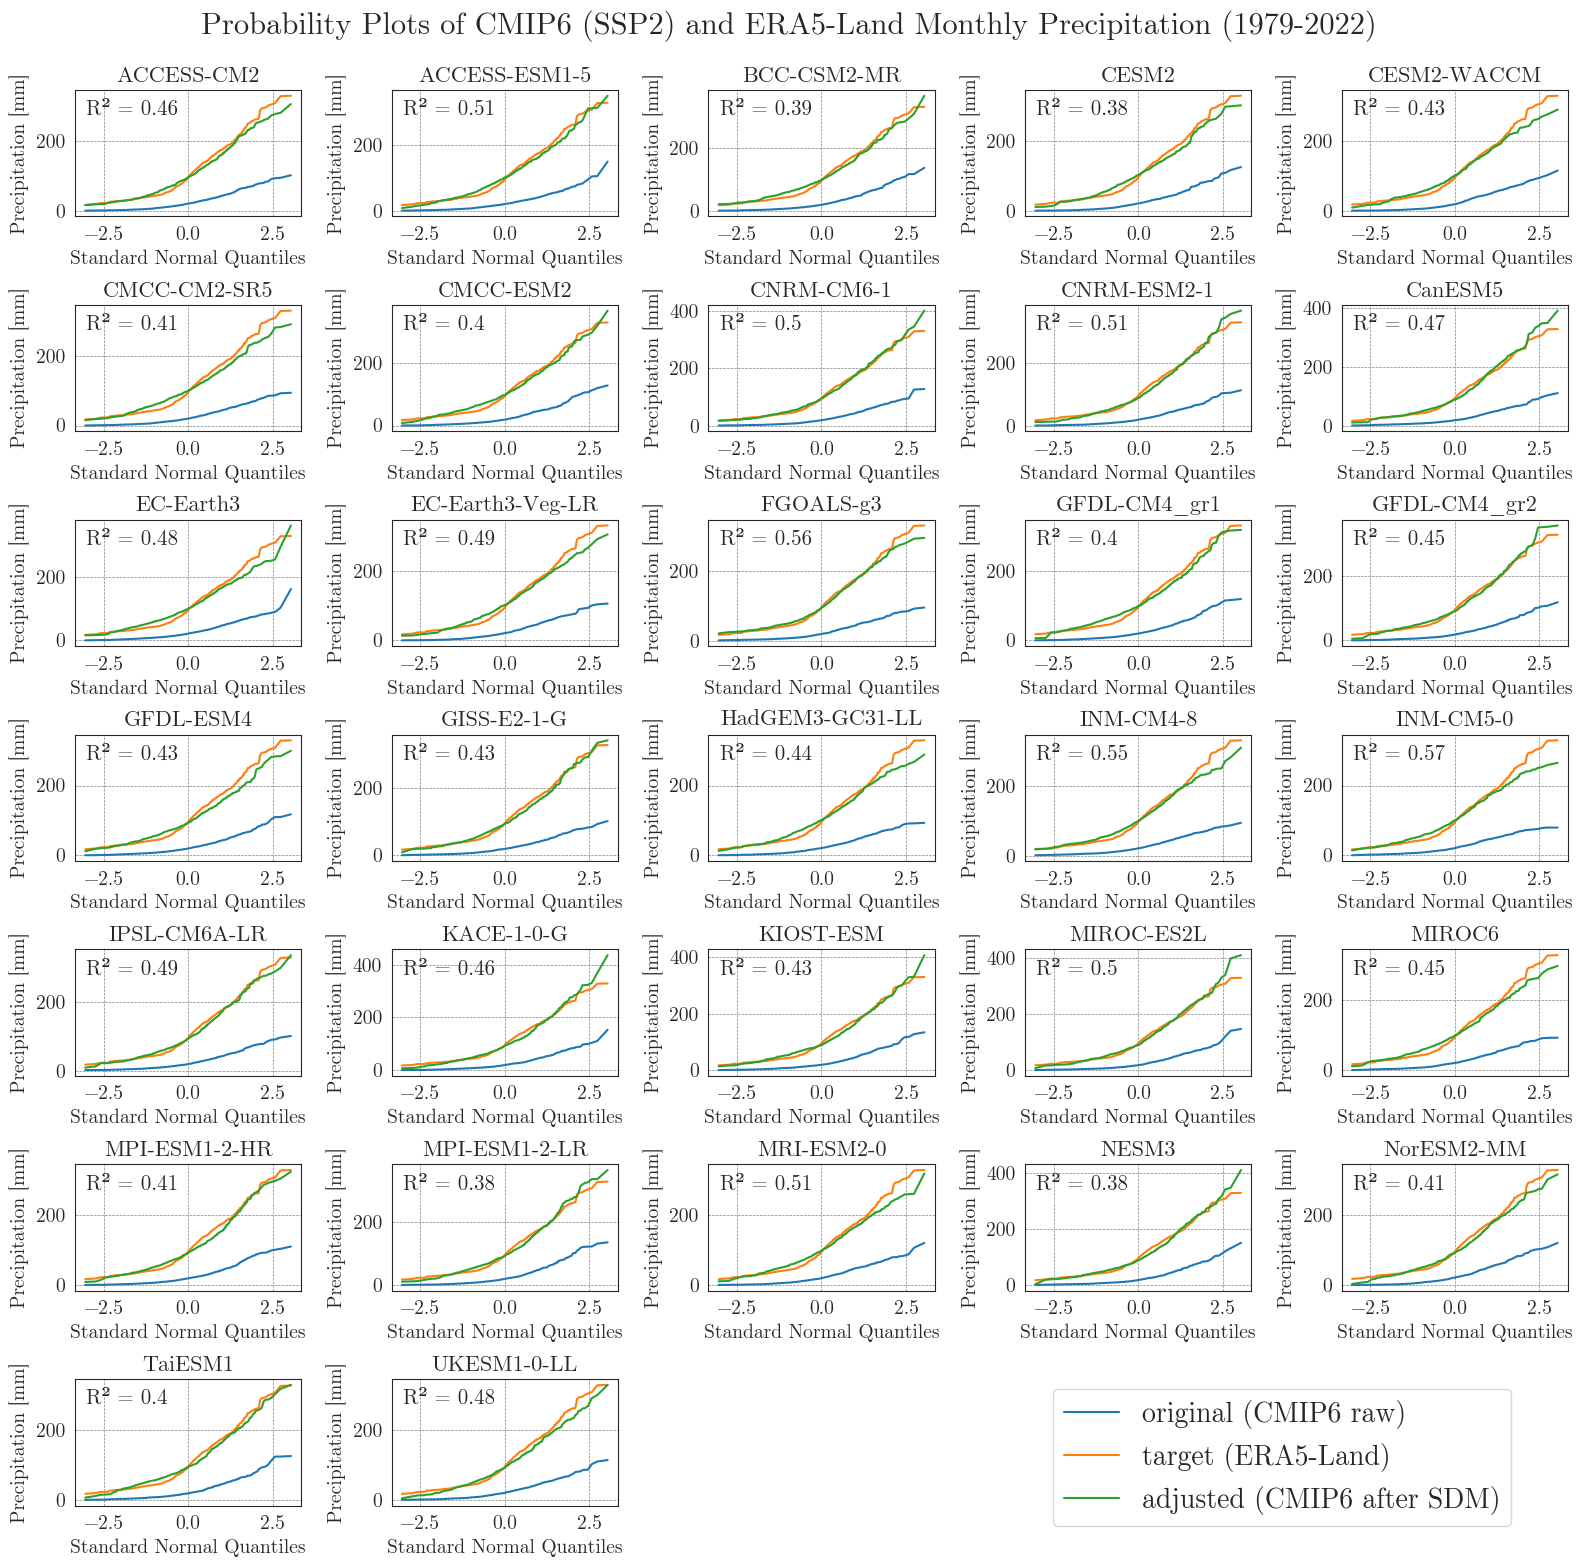

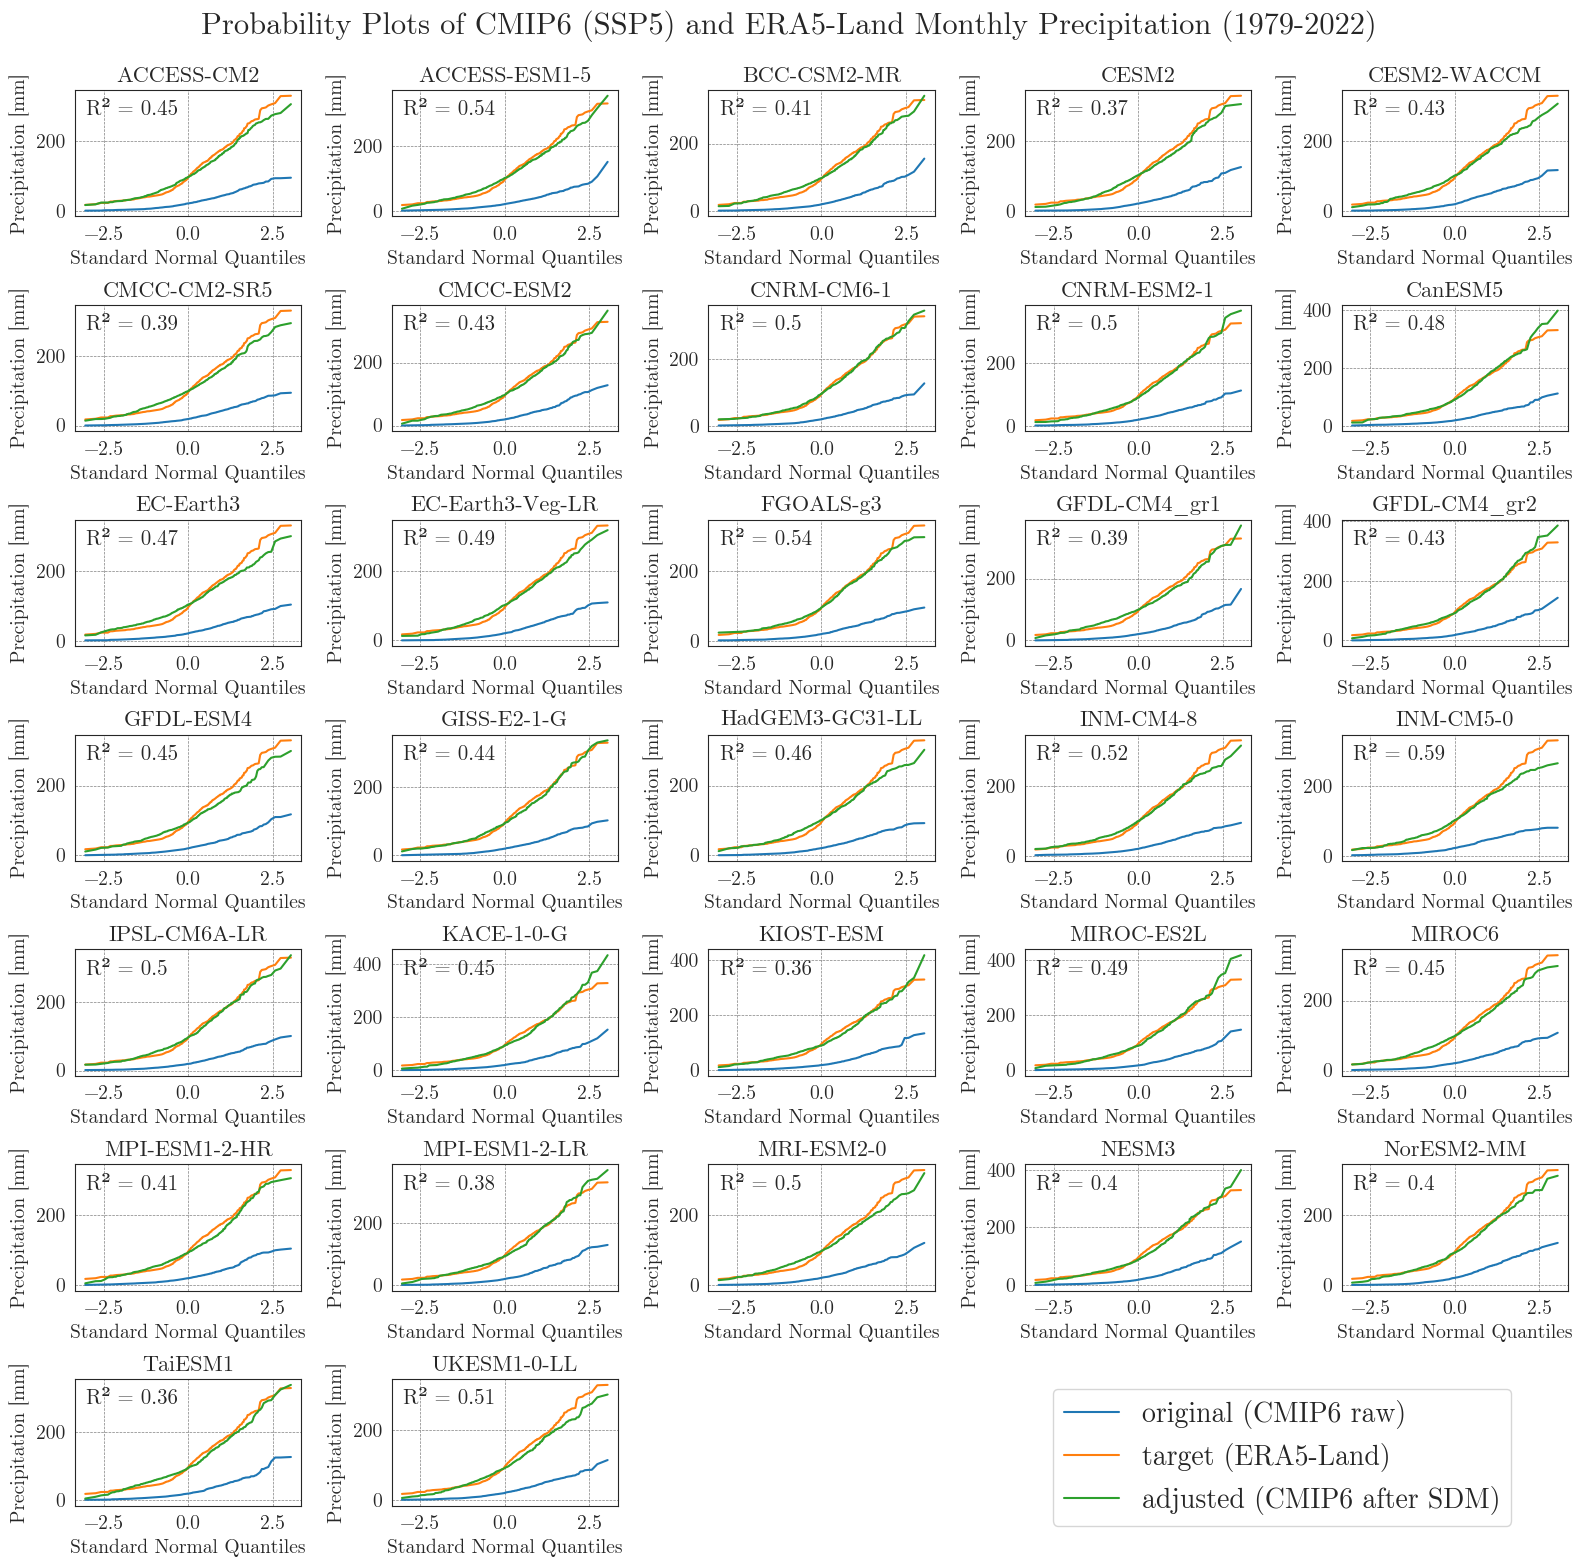

In [81]:
pp_matrix(ssp2_pr_raw, era5['prec'], ssp2_pr, precip=True, scenario='SSP2', show=True, fig_path=f'{dir_figures}NB3_CMIP6_SSP2_probability_Prec.png')
pp_matrix(ssp5_pr_raw, era5['prec'], ssp5_pr, precip=True, scenario='SSP5', show=True, fig_path=f'{dir_figures}NB3_CMIP6_SSP5_probability_Prec.png')

Considering the complexity and heterogeneity of precipitation data, the performance of the SDM is acceptable. Although the fitted data of most models differ from the target data at low and very high values, the general distribution of monthly precipitation is accurately represented.

## Write CMIP6 data to file

After a thorough review of the climate scenario data, we can write the final selection to files to be used in the next notebook. We want to use reanalysis data for the MATILDA model wherever possible and only use CMIP6 data for future projections. Therefore, we need to replace all of the data from our calibration period with ERA5-Land data.

In [82]:
from tools.helpers import replace_values


era5l = read_era5l(era5_file)
ssp2_tas = ssp_tas_dict['SSP2_adjusted'].copy()
ssp5_tas = ssp_tas_dict['SSP5_adjusted'].copy()
ssp2_pr = ssp_pr_dict['SSP2_adjusted'].copy()
ssp5_pr = ssp_pr_dict['SSP5_adjusted'].copy()

ssp2_tas = replace_values(ssp2_tas, era5l, 'temp')
ssp5_tas = replace_values(ssp5_tas, era5l, 'temp')
ssp2_pr = replace_values(ssp2_pr, era5l, 'prec')
ssp5_pr = replace_values(ssp5_pr, era5l, 'prec')

Since the whole ensemble results in relatively large files, we store the dictionaries in binary format. While these are not human-readable, they are compact and fast to read and write.

<div class="alert alert-block alert-info">
<b>Note:</b> In the config file you can choose between two storage options: <code>pickle</code> files are fast to read and write, but take up more disk space (<code>COMPACT_FILES = False</code>). You can use them on your local machine. <code>parquet</code> files need less disk space but take longer to read and write (<code>COMPACT_FILES = True</code>). They should be your choice in the Binder.</div>

In [83]:
from tools.helpers import dict_to_pickle, dict_to_parquet
import shutil

tas = {'SSP2': ssp2_tas, 'SSP5': ssp5_tas}
pr = {'SSP2': ssp2_pr, 'SSP5': ssp5_pr}

if compact_files:
    # For storage efficiency:
    dict_to_parquet(tas, cmip_dir + 'adjusted/tas_parquet')
    dict_to_parquet(pr, cmip_dir + 'adjusted/pr_parquet')
else:
    # For speed:
    dict_to_pickle(tas, cmip_dir + 'adjusted/tas.pickle')
    dict_to_pickle(pr, cmip_dir + 'adjusted/pr.pickle')

if zip_output:
    # refresh `output_download.zip` with data retrieved within this notebook
    shutil.make_archive('output_download', 'zip', 'output')
    print('Output folder can be download now (file output_download.zip)')

Output folder can be download now (file output_download.zip)


In [84]:
%reset -f

You can now continue with [Notebook 4](Notebook4_MATILDA.ipynb) to calibrate the MATILDA model.